Proyecto 2: Bioseñales y Sistemas


> Presentado por: Angie Melissa Londoño Castaño

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Se importan las librerias
import scipy.io as sio;
import numpy as np;
import matplotlib.pyplot as plt
import glob
import pandas as pd
import pywt

# Se importan los archivos
Rutas_EEG = glob.glob('/content/drive/Shareddrives/biosenales_sistemas/datasets_proyecto2/*.mat')

Mounted at /content/drive


Rutina 1: Detectar en una señal donde hay épocas atípicas (con valores de amplitud muy altos o muy bajos medidos respecto a la media +- desviaciones estándar) (10%)

In [ ]:
# El siguiente código recorre todos los archivos y extrae las señales, después las recorta para hacer un reshape
# y así dividir la señal en epocas

matrices = []     # En esta lista se van a almacenar los EEG en 3D, osea con el reshape
for ruta in Rutas_EEG:
  indice = Rutas_EEG.index(ruta)
  EEG = sio.loadmat(Rutas_EEG[indice]); #Este es el archivo que está en la ruta
  data = EEG['data'];     # Este data es la matriz de sensor x puntos
  tam_epoca = 5000    # tomando epocas de 5 segundos (para una fs = 1000 Hz)
  recorte = data[:,0:((int((data.shape[1])/tam_epoca))*tam_epoca)]    # las epocas quedan del mismo tamaño, se eliminan los puntos sobrantes
  EEG = np.reshape(recorte, (7,tam_epoca,(int((data.shape[1])/tam_epoca))))     # Reshape
  matrices.append(EEG)

# El siguiente códio es una función que detecta las epocas atípicas de la señal
def Detec_Ep_Atipica (signal, cuant_desv):
  '''
  Signal es una matriz 2D, cada signal es un canal o un sensor
  '''
  existe = 0
  promedio = np.mean(signal)
  desv_est = np.std(signal)     # Desviación estándar de la señal
  posicion = 0
  signal = np.transpose(signal)
  for epoca in signal:
    posicion += 1
    for punto in epoca:
      distancia = np.absolute(punto - promedio)
      criterio = cuant_desv * desv_est
      if distancia >= criterio:
        existe = 1
    if existe >= 1:
      print('La epoca ' + str(posicion) + ' es atípica')
    else:
      print('Esta epoca ' + str(posicion) + ' no es atípica')
    existe = 0

# El siguiente código recorre todas las 20 señales de EEC y retorna las epocas atípicas de cada señal
cuant_desv = float(input('Cuantas desviaciones est. mas que la media considera una epoca atípica: '))
pos = 0
for senal_3d in matrices:
  pos += 1
  print('\n \n Para el EEG # ' + str(pos) + ':')
  sen = 0
  for sensor in senal_3d:
    sen += 1
    print('   Para el sensor ' + str(sen) + ':')
    Detec_Ep_Atipica(sensor, cuant_desv)

Rutina 2: Aplicación de la limpieza Wavelet donde se debe poder (20%)

◦ Seleccionar el tipo de aplicación de umbralización (soft o hard)

◦ Seleccionar el tipo de estimación del umbral y el tipo de ponderación

In [ ]:
# Tipo de aplicación del umbral
def umbralizar (detalle, app_umbral, lamb, sigma):
  cont1=0
  if app_umbral == 0:     # Soft
    for punto in detalle:
      abso = np.absolute(punto)
      criterio = lamb*sigma
      if abso < criterio:
        detalle[cont1]=0
      else:
        detalle[cont1]=np.sign(punto)*(abso-lamb)
      cont1+=1
  elif app_umbral == 1:    # Hard
    detalle[np.absolute(detalle) < (lamb * sigma)] = 0
  else:
    print('Opción incorrecta')

def filtrar (vector):
  nivel = 4 # Para modificar el nivel cambiar aqui
  Wavelet = 'db4' # Para cambiar el tipo de wavelet cambiar aqui
  descomp = pywt.wavedec(vector, Wavelet, level=nivel)
  detalles = descomp[1:nivel+1]
  N = 5000

  # Estimación del umbral
  if est_umbral == 0:     # Univeral
    lamb = np.sqrt(2*np.log10(N))
  elif est_umbral == 1:     # Minimax
    lamb = 0.3936+0.1829*(np.log10(N)/(np.log10(2)))
  elif est_umbral == 2:
    n = N
    sx2=np.power(np.sort(np.abs(vector)),2)
    risks = (n-2*(np.arange(1,n+1))+np.cumsum(sx2)+(np.arange(0,n)[::-1])*sx2)/n
    min= np.min(risks)
    pos= np.where(risks==min)
    best=pos[0]
    thr=np.sqrt(sx2[best[0]])
    lamb = thr
  else:
    print('Opción incorrecta')

  # Tipo de ponderación
  if ponderacion == 0:
    sigma = 1
    for det in detalles:
      umbralizar (det, app_umbral, lamb, sigma)
  elif ponderacion == 1:
    sigma = (np.median(np.absolute(detalles[0])))/0.6745
    for det in detalles:
      umbralizar (det, app_umbral, lamb, sigma)
  elif ponderacion == 2:
    for niv in range (0,nivel):
      sigma = (np.median( np.absolute( detalles[niv]))) / (0.6745)
      umbralizar (detalles[niv], app_umbral, lamb, sigma)
  else:
    print ('Opción incorrecta')

  # Transformada inversa
  coeficientes = [descomp[0]]
  coeficientes.extend(detalles)
  senal_filtrada = pywt.waverec(coeficientes, Wavelet)
  return senal_filtrada

def Filtrar_sensor (signal, cuant_desv):
  '''
  Signal es una matriz 2D, cada signal es un canal o un sensor
  '''
  #print(signal)
  existe = 0
  promedio = np.mean(signal)
  desv_est = np.std(signal)     # Desviación estándar de la señal
  posicion = 0
  signal = np.transpose(signal)
  for epoca in signal:
    for punto in epoca:
      distancia = np.absolute(punto - promedio)
      criterio = cuant_desv * desv_est
      if distancia >= criterio:
        existe = 1
    if existe >= 1:
      filtro = filtrar(epoca)
      signal[posicion,:] = filtro # En esta linea se reemplaza la epoca por la señal filtrada
    existe = 0
    posicion += 1
  return signal

# Configuración de cada wavelet
app_umbral = int(input('\n Para un umbral Soft ingrese 0, Para un umbral Hard ingrese 1: '))
est_umbral = int(input('\n Para un umbral Universal ingrese 0, Para un umbral Minimax ingrese 1,  Para un umbral Sure ingrese 2: '))
ponderacion = int(input('\n Para una ponderacion One ingrese 0, Para Single level ingrese 1, Para Multilevel ingrese 2: '))

mat_filtradas = []
pos = 0
for senal_3d in matrices:
  print('\n \n Para el EEG # ' + str(pos) + ':')
  sen = 0
  for sensor in senal_3d:
    sefiltro = Filtrar_sensor(sensor, cuant_desv)
    sefiltro = np.transpose(sefiltro)
    senal_3d[sen] = sefiltro
    print('   Se filtró el sensor ' + str(sen))
    sen += 1
  mat_filtradas.append(senal_3d)
  pos += 1

In [ ]:
matrices_originales = []     # En esta lista se van a almacenar los EEG en 3D, osea con el reshape
for ruta in Rutas_EEG:
  indice = Rutas_EEG.index(ruta)
  EEG = sio.loadmat(Rutas_EEG[indice]); #Este es el archivo que está en la ruta
  data = EEG['data'];     # Este data es la matriz de sensor x puntos
  tam_epoca = 5000    # tomando epocas de 5 segundos (para una fs = 1000 Hz)
  recorte = data[:,0:((int((data.shape[1])/tam_epoca))*tam_epoca)]    # las epocas quedan del mismo tamaño, se eliminan los puntos sobrantes
  EEG = np.reshape(recorte, (7,tam_epoca,(int((data.shape[1])/tam_epoca))))     # Reshape
  matrices_originales.append(EEG)

In [ ]:
# En esta sección se restan las señales
cont=0
matrices_EEG=[]
for matriz in matrices_originales:
  orig = mat_filtradas[cont]
  matrices_EEG.append(orig-matriz)
  cont+=1

Rutina 3: Realizar una gráfica comparativa entre la señal sin filtrar y con filtro. Se valorará el nivel de detalle y calidad de los gráficos obtenidos (10%)


In [ ]:
pos = 0
for senal_3d in matrices_originales:
  print('Graficas para el paciente:' + str(pos))
  sen = 0
  for sensor in senal_3d:
    signal_completa_original = sensor.flatten('F')
    matriz_filtrada = matrices_EEG[pos]
    signal_completa_filtrada = matriz_filtrada[sen].flatten('F')
    tiempo = np.arange(0, signal_completa_original.size/1000, 1/1000)
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(tiempo, signal_completa_original, 'r', label='Señal sin filtro')
    plt.ylabel('Amplitud')
    plt.legend(loc = 'upper left')
    plt.title('Grafica comparativa del sensor ' + str(sen))
    plt.grid()
    plt.subplot(2,1,2)
    plt.plot(tiempo, signal_completa_filtrada, 'b', label = 'Señal con filtro')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')
    plt.legend(loc = 'upper left')
    plt.grid()
    plt.show()
    sen += 1
  pos += 1

Energía de la señal

In [ ]:
def energy(signal):
    energy = np.sum(np.power(signal,2));
    return energy;

In [ ]:
#Para las 20 señales se saca la energia de cada señal
lista1=[];lista1=[];lista2=[];lista3=[];lista4=[];lista5=[];lista6=[];lista7=[]
for senal in matrices_originales:
  canal1=senal[0,:,:];canal2=senal[1,:,:];canal3=senal[2,:,:];canal4=senal[3,:,:]
  canal5=senal[4,:,:];canal6=senal[5,:,:];canal7=senal[6,:,:]

  energia1= energy(canal1[:]);energia2= energy(canal2[:]);energia3= energy(canal3[:]);energia4= energy(canal4[:])
  energia5= energy(canal5[:]);energia6= energy(canal6[:]);energia7= energy(canal7[:])

  lista1.append(energia1);lista2.append(energia2);lista3.append(energia3);
  lista4.append(energia4);lista5.append(energia5);lista6.append(energia6);
  lista7.append(energia7)

  lista_energias=[lista1,lista2,lista3,lista4,lista5,lista6,lista7]

  energia_promedio1=np.mean(lista1);energia_promedio2=np.mean(lista2);energia_promedio3=np.mean(lista3)
  energia_promedio4=np.mean(lista4);energia_promedio5=np.mean(lista5);energia_promedio6=np.mean(lista6)
  energia_promedio7=np.mean(lista7)

  energias_promedios=[energia_promedio1,energia_promedio2,energia_promedio3,energia_promedio4,energia_promedio5,energia_promedio6,energia_promedio7]

In [ ]:
#Para las 20 señales filtradas se saca la energia promedio de cada señal
lista1=[];lista1=[];lista2=[];lista3=[];lista4=[];lista5=[];lista6=[];lista7=[]
for senal in mat_filtradas:
  canal1=senal[0,:,:];canal2=senal[1,:,:];canal3=senal[2,:,:];canal4=senal[3,:,:]
  canal5=senal[4,:,:];canal6=senal[5,:,:];canal7=senal[6,:,:]

  energia1= energy(canal1[:]);energia2= energy(canal2[:]);energia3= energy(canal3[:]);energia4= energy(canal4[:])
  energia5= energy(canal5[:]);energia6= energy(canal6[:]);energia7= energy(canal7[:])

  lista1.append(energia1);lista2.append(energia2);lista3.append(energia3);
  lista4.append(energia4);lista5.append(energia5);lista6.append(energia6);
  lista7.append(energia7)

  lista_energias_filt=[lista1,lista2,lista3,lista4,lista5,lista6,lista7]

  energia_promedio1=np.mean(lista1);energia_promedio2=np.mean(lista2);energia_promedio3=np.mean(lista3)
  energia_promedio4=np.mean(lista4);energia_promedio5=np.mean(lista5);energia_promedio6=np.mean(lista6)
  energia_promedio7=np.mean(lista7)

  energias_promedios_filt=[energia_promedio1,energia_promedio2,energia_promedio3,energia_promedio4,energia_promedio5,energia_promedio6,energia_promedio7]

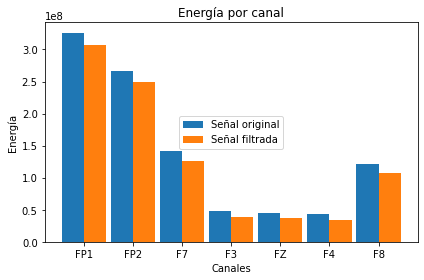

In [ ]:
#HISTOGRAMA
labels = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8']

x = np.arange(len(labels))  # the label locations
width = 0.45 # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, energias_promedios, width, label='Señal original')
rects2 = ax.bar(x + width/2, energias_promedios_filt, width, label='Señal filtrada')

ax.set_ylabel('Energía')
ax.set_xlabel('Canales')
ax.set_title('Energía por canal')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="center")

fig.tight_layout()

plt.show()

In [ ]:
# CAJAS Y BIGOTES POR CANAL
plt.figure(figsize=(20,10))
h=0
for i in range(1,8):
  data = [np.squeeze(lista_energias[h]),np.squeeze(lista_energias_filt[h])]
  plt.subplot(2,4, i)
  plt.boxplot(data)
  canales = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8']
  plt.title('Canal ' +  canales[h])
  h +=1
plt.show()

In [ ]:
# Shapiro-Wilk Normality Test (señal orginal)
from scipy import stats
i=0
for i in range(0,7):
  from scipy.stats import shapiro
  data = np.squeeze(lista_energias[i])
  stat, p = shapiro(data)
  print('stat=%.3f, p=%.3f' % (stat, p))
  canales = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8']
  if p > 0.05:
	  print('Probabilidad Gaussiana para el canal '+canales[i]+' de la señal original')
  else:
	  print('Probabilidad no Gaussian para el canal '+canales[i]+' de la señal original')
  i=i+1

In [ ]:
# Shapiro-Wilk Normality Test (señal filtrada)
from scipy import stats
i=0
for i in range(0,7):
  from scipy.stats import shapiro
  data = np.squeeze(lista_energias_filt[i])
  stat, p = shapiro(data)
  print('stat=%.3f, p=%.3f' % (stat, p))
  canales = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8']
  if p > 0.05:
	  print('Probabilidad Gaussiana para el canal '+ canales[i]+' de la señal filtrada')
  else:
	  print('Probabilidad no Gaussian para el canal '+ canales[i]+' de la señal filtrada')
  i=i+1

In [ ]:
#Prueba no parametrica (the Mann-Whitney U Test)
for i in range(0,7):
  from scipy.stats import mannwhitneyu
  data1 = np.squeeze(lista_energias[i])
  data2 = np.squeeze(lista_energias_filt[i])
  stat, p = mannwhitneyu(data1, data2)
  print('stat=%.3f, p=%.3f' % (stat, p))
  canales = ['FP1', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8']
  if p > 0.05:
	  print('Probablemente igual distribucion para los canales '+ canales[i])
  else:
	  print('Probablemente diferente distribucion para los canales '+ canales[i])
  i=i+1